# # Find out which relations between different Indian spices 

Indian food, like most of the food from the tropical region, uses lots of different spices. Historically, the spices are thought to have been a way to increase shelf-life and keep pests away. Anyways, now if you are planning to cook more Indian food lately, it would be great to know which spices would give you most bang for your buck. More so, which spices are often used together? What is the relation between each of them? 

Recently I found a dataset from Kaggle which tabulated 6000+ recipes from https://www.archanaskitchen.com/. Using this data as base collection of recipes representing most of the indian food, I analyze which spices occur most freqeuntly and which spices are most connected to each other. 

* Dataset for Indian recipe: This dataset 6000+ recipe scrapped from  | [Link to the dataset](https://www.kaggle.com/kanishk307/6000-indian-food-recipes-dataset)

In [1]:
import pandas as pd 
import numpy as np 

In [2]:
#----- PLOTTING PARAMS ----# 
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
 
plot_params = {
'font.size' : 22,
'axes.titlesize' : 24,
'axes.labelsize' : 20,
#'lines.linewidth' : 3,
#'lines.markersize' : 10,
'xtick.labelsize' : 16,
'ytick.labelsize' : 16,
}
 
plt.rcParams.update(plot_params)

### ### Read the dataset

In [3]:
food_df = pd.read_csv('./archive/IndianFoodDatasetCSV.csv')

In [4]:
food_df.columns

Index(['Srno', 'RecipeName', 'TranslatedRecipeName', 'Ingredients',
       'TranslatedIngredients', 'PrepTimeInMins', 'CookTimeInMins',
       'TotalTimeInMins', 'Servings', 'Cuisine', 'Course', 'Diet',
       'Instructions', 'TranslatedInstructions', 'URL'],
      dtype='object')

In [5]:
food_df.shape

(6871, 15)

In [6]:
# dropping miscellaneous columns 
columns_to_drop = ['CookTimeInMins', 'Servings', 'Course', 'Diet', 'Instructions', 'TranslatedInstructions', 'URL']
food_df = food_df.drop(columns = columns_to_drop).dropna()

In [7]:
# data has indian-inspired international cuisines which are not what we are interested in
cuisines_to_drop = ['Mexican', 'Italian Recipes', 'Thai', 'Chinese', 'Asian', 'Middle Eastern', 'European',
                   'Arab', 'Japanese', 'Vietnamese', 'British', 'Greek', 'French', 'Mediterranean', 'Sri Lankan',
                   'Indonesian', 'African', 'Korean', 'American', 'Carribbean', 'World Breakfast', 'Malaysian', 'Dessert',
                   'Afghan', 'Snack', 'Jewish', 'Brunch', 'Lunch', 'Continental', 'Fusion']

food_df = food_df.loc[ ~ food_df['Cuisine'].isin(cuisines_to_drop) ] #Dropping entries in `food_df` which have non-indian cuisines 

In [8]:
food_df.shape

(4881, 8)

In [9]:
food_df.head(5)

,Srno,RecipeName,TranslatedRecipeName,Ingredients,TranslatedIngredients,PrepTimeInMins,TotalTimeInMins,Cuisine
0,1,Masala Karela Recipe,Masala Karela Recipe,"6 Karela (Bitter Gourd/ Pavakkai) - deseeded,S...","6 Karela (Bitter Gourd/ Pavakkai) - deseeded,S...",15,45,Indian
1,2,टमाटर पुलियोगरे रेसिपी - Spicy Tomato Rice (Re...,Spicy Tomato Rice (Recipe),"2-1/2 कप चावल - पका ले,3 टमाटर,3 छोटा चमच्च बी...","2-1 / 2 cups rice - cooked, 3 tomatoes, 3 teas...",5,15,South Indian Recipes
2,3,Ragi Semiya Upma Recipe - Ragi Millet Vermicel...,Ragi Semiya Upma Recipe - Ragi Millet Vermicel...,"1-1/2 cups Rice Vermicelli Noodles (Thin),1 On...","1-1/2 cups Rice Vermicelli Noodles (Thin),1 On...",20,50,South Indian Recipes
3,4,Gongura Chicken Curry Recipe - Andhra Style Go...,Gongura Chicken Curry Recipe - Andhra Style Go...,"500 grams Chicken,2 Onion - chopped,1 Tomato -...","500 grams Chicken,2 Onion - chopped,1 Tomato -...",15,45,Andhra
4,5,आंध्रा स्टाइल आलम पचड़ी रेसिपी - Adrak Chutney ...,Andhra Style Alam Pachadi Recipe - Adrak Chutn...,"1 बड़ा चमच्च चना दाल,1 बड़ा चमच्च सफ़ेद उरद दाल,2...","1 tablespoon chana dal, 1 tablespoon white ura...",10,30,Andhra


In [10]:
# Some entries in the `TranslatedIngredients` have non-english entries 
def filter_english(string):
    try:
        string.encode('utf-8').decode('ascii')
        out = True
    except UnicodeDecodeError: 
        out = False
    return out

In [11]:
# Droping columns in the dataset having ingredients in language other than english 
df = food_df.loc[ food_df['TranslatedIngredients'].apply(filter_english) ]

In [12]:
df.shape

(4273, 8)

## ## Generate a consistent list of Indian spices for better tabulation

In [13]:
#read file of all indian spices on wikipedia
wiki_file_pd = pd.read_html('https://en.wikipedia.org/wiki/List_of_Indian_spices')
spices_list = wiki_file_pd[0]['Standard English'].copy().str.lower()

#some important spices to add
spices_to_add = pd.Series(['black salt', 'green chillies', 'chilli powder'])

#some spices are too common (such as pepper) or not a spice, but a vegetable, or are otherwise corrupted (for example,
#cardamom is often listed as "cardamom" nto specifying whether it is black or green)

spices_to_drop = ['black pepper', 'capers', 'chili pepper powder', 'cinnamon buds', 'citric acid', 'garlic', 'capsicum', 'charoli', 'garcinia gummi-gutta', 'inknut', 'garcinia indica',
                  'black mustard seeds/raee', 'cumin seed ground into balls', 'dried ginger', 'green chili pepper', 'long pepper', 'four seeds', 'cubeb', 'gum tragacanth', 'jakhya', 'licorice powder',
                  'indian bedellium tree', 'mango extract', 'coriander powder', 'saffron pulp', 'black cardamom', 'brown mustard seed', 'black cumin', 'panch phoron']

spices_list = spices_list.loc[ ~spices_list.isin(spices_to_drop) ].append(spices_to_add).reset_index(drop=True)

In [14]:
spices_list

0                      alkanet root
1                           amchoor
2                        asafoetida
3                       peppercorns
4             celery / radhuni seed
5         bay leaf, indian bay leaf
6                          cinnamon
7                            cloves
8                    coriander seed
9                        cumin seed
10    curry tree or sweet neem leaf
11                      fennel seed
12                   fenugreek leaf
13                   fenugreek seed
14                     garam masala
15                           ginger
16                   green cardamom
17                indian gooseberry
18                          kalpasi
19                     mustard seed
20                     nigella seed
21                           nutmeg
22                             mace
23                 pomegranate seed
24                       poppy seed
25                          saffron
26                      sesame seed
27                       sta

In [15]:
#editing the spices so that my string counter can find different versions of the same spice
spices_list = spices_list.str.replace('amchoor', 'amchur/amchoor/mango extract') \
                    .replace('asafoetida', 'asafetida/asafoetida/hing') \
                    .replace('thymol/carom seed', 'ajwain/thymol/carom seed') \
                    .replace('alkanet root', 'alkanet/alkanet root') \
                    .replace('chilli powder', 'red chilli powder/chilli powder/kashmiri red chilli powder') \
                    .replace('celery / radhuni seed', 'celery/radhuni seed') \
                    .replace('bay leaf, indian bay leaf', 'bay leaf/bay leaves/tej patta') \
                    .replace('curry tree or sweet neem leaf', 'curry leaf/curry leaves') \
                    .replace('fenugreek leaf', 'fenugreek/kasoori methi') \
                    .replace('nigella seed', 'nigella/black cumin') \
                    .replace('ginger', 'dried ginger/ginger powder') \
                    .replace('cloves', 'cloves/laung') \
                    .replace('green cardamom', 'cardamom/green cardamom/black cardamom')\
                    .replace('indian gooseberry', 'indian gooseberry/amla')\
                    .replace('coriander seed', 'coriander seed/coriander powder')\
                    .replace('cumin seed', 'cumin powder/cumin seeds/cumin/jeera')

In [16]:
spices_list

0                                  alkanet/alkanet root
1                          amchur/amchoor/mango extract
2                             asafetida/asafoetida/hing
3                                           peppercorns
4                                   celery/radhuni seed
5                         bay leaf/bay leaves/tej patta
6                                              cinnamon
7                                          cloves/laung
8                       coriander seed/coriander powder
9                  cumin powder/cumin seeds/cumin/jeera
10                              curry leaf/curry leaves
11                                          fennel seed
12                              fenugreek/kasoori methi
13                                       fenugreek seed
14                                         garam masala
15                           dried ginger/ginger powder
16               cardamom/green cardamom/black cardamom
17                               indian gooseber

## ## Ingredients in the recipes

In [17]:
ingredients_series = df[['TranslatedRecipeName','TranslatedIngredients']]

In [18]:
ingredients_series

,TranslatedRecipeName,TranslatedIngredients
0,Masala Karela Recipe,"6 Karela (Bitter Gourd/ Pavakkai) - deseeded,S..."
1,Spicy Tomato Rice (Recipe),"2-1 / 2 cups rice - cooked, 3 tomatoes, 3 teas..."
2,Ragi Semiya Upma Recipe - Ragi Millet Vermicel...,"1-1/2 cups Rice Vermicelli Noodles (Thin),1 On..."
3,Gongura Chicken Curry Recipe - Andhra Style Go...,"500 grams Chicken,2 Onion - chopped,1 Tomato -..."
4,Andhra Style Alam Pachadi Recipe - Adrak Chutn...,"1 tablespoon chana dal, 1 tablespoon white ura..."
...,...,...
6861,One Pot Punjabi Rajma Masala Recipe In Preethi...,"1 cup Rajma (Large Kidney Beans),1 inch Ginger..."
6863,Saffron Paneer Peda Recipe,2 cups Paneer (Homemade Cottage Cheese) - crum...
6865,Quinoa Phirnee Recipe (Quinoa Milk Pudding),"1 cup Quinoa,3/4 cup Sugar,1 teaspoon Cardamom..."
6868,Ullikadala Pulusu Recipe | Spring Onion Curry,150 grams Spring Onion (Bulb & Greens) - chopp...


In [19]:
ingredients_series[spices_list.to_list()] = 42 

/Users/pghaneka/miniconda3/envs/ml_torch/lib/python3.6/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan


In [20]:
ingredients_series

,TranslatedRecipeName,TranslatedIngredients,alkanet/alkanet root,amchur/amchoor/mango extract,asafetida/asafoetida/hing,peppercorns,celery/radhuni seed,bay leaf/bay leaves/tej patta,cinnamon,cloves/laung,...,saffron,sesame seed,star anise,tamarind,ajwain/thymol/carom seed,turmeric,white pepper,black salt,green chillies,red chilli powder/chilli powder/kashmiri red chilli powder
0,Masala Karela Recipe,"6 Karela (Bitter Gourd/ Pavakkai) - deseeded,S...",42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
1,Spicy Tomato Rice (Recipe),"2-1 / 2 cups rice - cooked, 3 tomatoes, 3 teas...",42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
2,Ragi Semiya Upma Recipe - Ragi Millet Vermicel...,"1-1/2 cups Rice Vermicelli Noodles (Thin),1 On...",42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
3,Gongura Chicken Curry Recipe - Andhra Style Go...,"500 grams Chicken,2 Onion - chopped,1 Tomato -...",42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
4,Andhra Style Alam Pachadi Recipe - Adrak Chutn...,"1 tablespoon chana dal, 1 tablespoon white ura...",42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6861,One Pot Punjabi Rajma Masala Recipe In Preethi...,"1 cup Rajma (Large Kidney Beans),1 inch Ginger...",42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
6863,Saffron Paneer Peda Recipe,2 cups Paneer (Homemade Cottage Cheese) - crum...,42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
6865,Quinoa Phirnee Recipe (Quinoa Milk Pudding),"1 cup Quinoa,3/4 cup Sugar,1 teaspoon Cardamom...",42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
6868,Ullikadala Pulusu Recipe | Spring Onion Curry,150 grams Spring Onion (Bulb & Greens) - chopp...,42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42


## ## Using the spice_list to find spice name in the recipe  

In [21]:
# Convenience function to search a given ingredient list for spice names -- I tried pandas.Series.str.contains 
import re 
def search_spice(ingredient_string, spice_string):
    spice_list = spice_string.split('/')
    for _spice in spice_list:
        if re.search(_spice.lower(), ingredient_string.lower()):
            return True
            break

In [22]:
for row, values in ingredients_series.iterrows():
    for spice_entry in spices_list:
        if search_spice(values['TranslatedIngredients'], spice_entry):
            ingredients_series.loc[row, spice_entry] = 1
        else:
            ingredients_series.loc[row, spice_entry] = 0

In [23]:
food_spice_mix = ingredients_series.drop(['TranslatedIngredients'], axis=1).reset_index(drop=True)

In [24]:
#editing the spices so that my string counter can find different versions of the same spice
food_spice_mix.rename(columns={'amchur/amchoor/mango extract':'amchoor', \
                    'asafetida/asafoetida/hing': 'asafoetida', \
                    'ajwain/thymol/carom seed': 'ajwain', \
                    'alkanet/alkanet root': 'alkanet root', \
                    'red chilli powder/chilli powder/kashmiri red chilli powder': 'chilli powder', \
                    'celery/radhuni seed': 'celery seeds',\
                    'bay leaf/bay leaves/tej patta': 'bay leaf', \
                    'curry leaf/curry leaves': 'curry leaves',\
                    'fenugreek/kasoori methi': 'fenugreek leaf', \
                    'nigella/black cumin': 'nigella seed', \
                    'ginger': 'dried ginger',\
                    'cloves/laung': 'cloves', \
                    'cardamom/green cardamom/black cardamom': 'cardamom',\
                    'indian gooseberry/amla': 'indian gooseberry',\
                    'coriander seed/coriander powder': 'coriander seeds/powder',\
                    'cumin powder/cumin seeds/cumin/jeera': 'cumin seeds/powder',\
                    'dried ginger/ginger powder': 'ginger powder'}, inplace=True)

In [25]:
food_spice_mix.columns

Index(['TranslatedRecipeName', 'alkanet root', 'amchoor', 'asafoetida',
       'peppercorns', 'celery seeds', 'bay leaf', 'cinnamon', 'cloves',
       'coriander seeds/powder', 'cumin seeds/powder', 'curry leaves',
       'fennel seed', 'fenugreek leaf', 'fenugreek seed', 'garam masala',
       'ginger powder', 'cardamom', 'indian gooseberry', 'kalpasi',
       'mustard seed', 'nigella seed', 'nutmeg', 'mace', 'pomegranate seed',
       'poppy seed', 'saffron', 'sesame seed', 'star anise', 'tamarind',
       'ajwain', 'turmeric', 'white pepper', 'black salt', 'green chillies',
       'chilli powder'],
      dtype='object')

In [26]:
food_spice_mix = food_spice_mix.sort_index(axis=1)

## ## Generating a spice adjacency matrix

In [27]:
num_spice = len(spices_list)
spice_col_name = [i for i in food_spice_mix.columns[1:].to_list()]
spice_adj = pd.DataFrame(np.zeros(shape=(len(spices_list),len(spices_list))), columns= spice_col_name, index=spice_col_name)
spice_adj_freq = pd.DataFrame(np.zeros(shape=(len(spices_list),len(spices_list))), columns= spice_col_name, index=spice_col_name)

In [28]:
for row, value in food_spice_mix.iterrows():
    for i in spice_col_name:
        for j in spice_col_name:
            if (value[i] == 1) & (value[j] == 1):
                spice_adj_freq.loc[i,j] += 1
                spice_adj.loc[i,j] = 1

In [29]:
spice_adj_freq = spice_adj_freq/len(food_spice_mix) * 100

In [30]:
spice_adj_freq.round(2)

,ajwain,alkanet root,amchoor,asafoetida,bay leaf,black salt,cardamom,celery seeds,chilli powder,cinnamon,...,nutmeg,peppercorns,pomegranate seed,poppy seed,saffron,sesame seed,star anise,tamarind,turmeric,white pepper
ajwain,5.22,0.00,0.70,1.45,0.98,0.07,1.05,0.00,3.49,1.33,...,0.16,0.75,0.09,0.23,0.21,0.40,0.23,0.37,2.97,0.00
alkanet root,0.00,0.07,0.00,0.07,0.05,0.00,0.07,0.00,0.07,0.07,...,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
amchoor,0.70,0.00,4.98,1.54,0.37,0.21,0.35,0.02,3.86,0.47,...,0.00,0.23,0.14,0.02,0.05,0.26,0.05,0.33,3.51,0.02
asafoetida,1.45,0.07,1.54,24.60,1.33,0.30,1.61,0.21,9.69,1.87,...,0.14,1.83,0.09,0.54,0.28,1.57,0.26,5.17,15.05,0.02
bay leaf,0.98,0.05,0.37,1.33,10.70,0.09,6.04,0.07,6.72,6.65,...,0.61,2.08,0.12,0.75,0.66,0.16,1.10,0.26,7.54,0.07
black salt,0.07,0.00,0.21,0.30,0.09,1.64,0.09,0.02,0.61,0.09,...,0.00,0.07,0.09,0.00,0.09,0.02,0.02,0.28,0.33,0.00
cardamom,1.05,0.07,0.35,1.61,6.04,0.09,17.79,0.14,6.13,7.98,...,1.08,2.74,0.23,1.47,3.14,0.35,1.29,0.42,6.60,0.07
celery seeds,0.00,0.00,0.02,0.21,0.07,0.02,0.14,0.80,0.37,0.19,...,0.09,0.02,0.00,0.00,0.02,0.00,0.02,0.00,0.51,0.00
chilli powder,3.49,0.07,3.86,9.69,6.72,0.61,6.13,0.37,37.96,7.04,...,0.44,2.78,0.47,1.38,0.68,1.59,0.82,3.58,28.39,0.05
cinnamon,1.33,0.07,0.47,1.87,6.65,0.09,7.98,0.19,7.04,13.13,...,0.96,3.58,0.19,1.40,0.84,0.23,1.38,0.89,8.10,0.07


In [31]:
temp_name = [i.title() for i in spice_adj_freq.index.to_list()]
spice_adj_freq['Plot_name'] = temp_name

In [32]:
spice_adj_freq = spice_adj_freq.set_index('Plot_name')

In [33]:
spice_adj_freq.columns = temp_name

In [34]:
spice_adj_freq

,Ajwain,Alkanet Root,Amchoor,Asafoetida,Bay Leaf,Black Salt,Cardamom,Celery Seeds,Chilli Powder,Cinnamon,...,Nutmeg,Peppercorns,Pomegranate Seed,Poppy Seed,Saffron,Sesame Seed,Star Anise,Tamarind,Turmeric,White Pepper
Plot_name,,,,,,,,,,,,,,,,,,,,,
Ajwain,5.218816,0.000000,0.702083,1.450971,0.982916,0.070208,1.053124,0.000000,3.487011,1.333957,...,0.163819,0.748888,0.093611,0.234028,0.210625,0.397847,0.234028,0.374444,2.972151,0.000000
Alkanet Root,0.000000,0.070208,0.000000,0.070208,0.046806,0.000000,0.070208,0.000000,0.070208,0.070208,...,0.000000,0.046806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Amchoor,0.702083,0.000000,4.984788,1.544582,0.374444,0.210625,0.351041,0.023403,3.861456,0.468055,...,0.000000,0.234028,0.140417,0.023403,0.046806,0.257430,0.046806,0.327639,3.510414,0.023403
Asafoetida,1.450971,0.070208,1.544582,24.596302,1.333957,0.304236,1.614791,0.210625,9.688743,1.872221,...,0.140417,1.825415,0.093611,0.538264,0.280833,1.567985,0.257430,5.172010,15.047976,0.023403
Bay Leaf,0.982916,0.046806,0.374444,1.333957,10.695062,0.093611,6.037912,0.070208,6.716593,6.646384,...,0.608472,2.082846,0.117014,0.748888,0.655277,0.163819,1.099930,0.257430,7.535689,0.070208
Black Salt,0.070208,0.000000,0.210625,0.304236,0.093611,1.638193,0.093611,0.023403,0.608472,0.093611,...,0.000000,0.070208,0.093611,0.000000,0.093611,0.023403,0.023403,0.280833,0.327639,0.000000
Cardamom,1.053124,0.070208,0.351041,1.614791,6.037912,0.093611,17.786099,0.140417,6.131524,7.980342,...,1.076527,2.738123,0.234028,1.474374,3.135970,0.351041,1.287152,0.421250,6.599579,0.070208
Celery Seeds,0.000000,0.000000,0.023403,0.210625,0.070208,0.023403,0.140417,0.795694,0.374444,0.187222,...,0.093611,0.023403,0.000000,0.000000,0.023403,0.000000,0.023403,0.000000,0.514861,0.000000
Chilli Powder,3.487011,0.070208,3.861456,9.688743,6.716593,0.608472,6.131524,0.374444,37.959279,7.044231,...,0.444652,2.784929,0.468055,1.380763,0.678680,1.591388,0.819097,3.580623,28.387550,0.046806


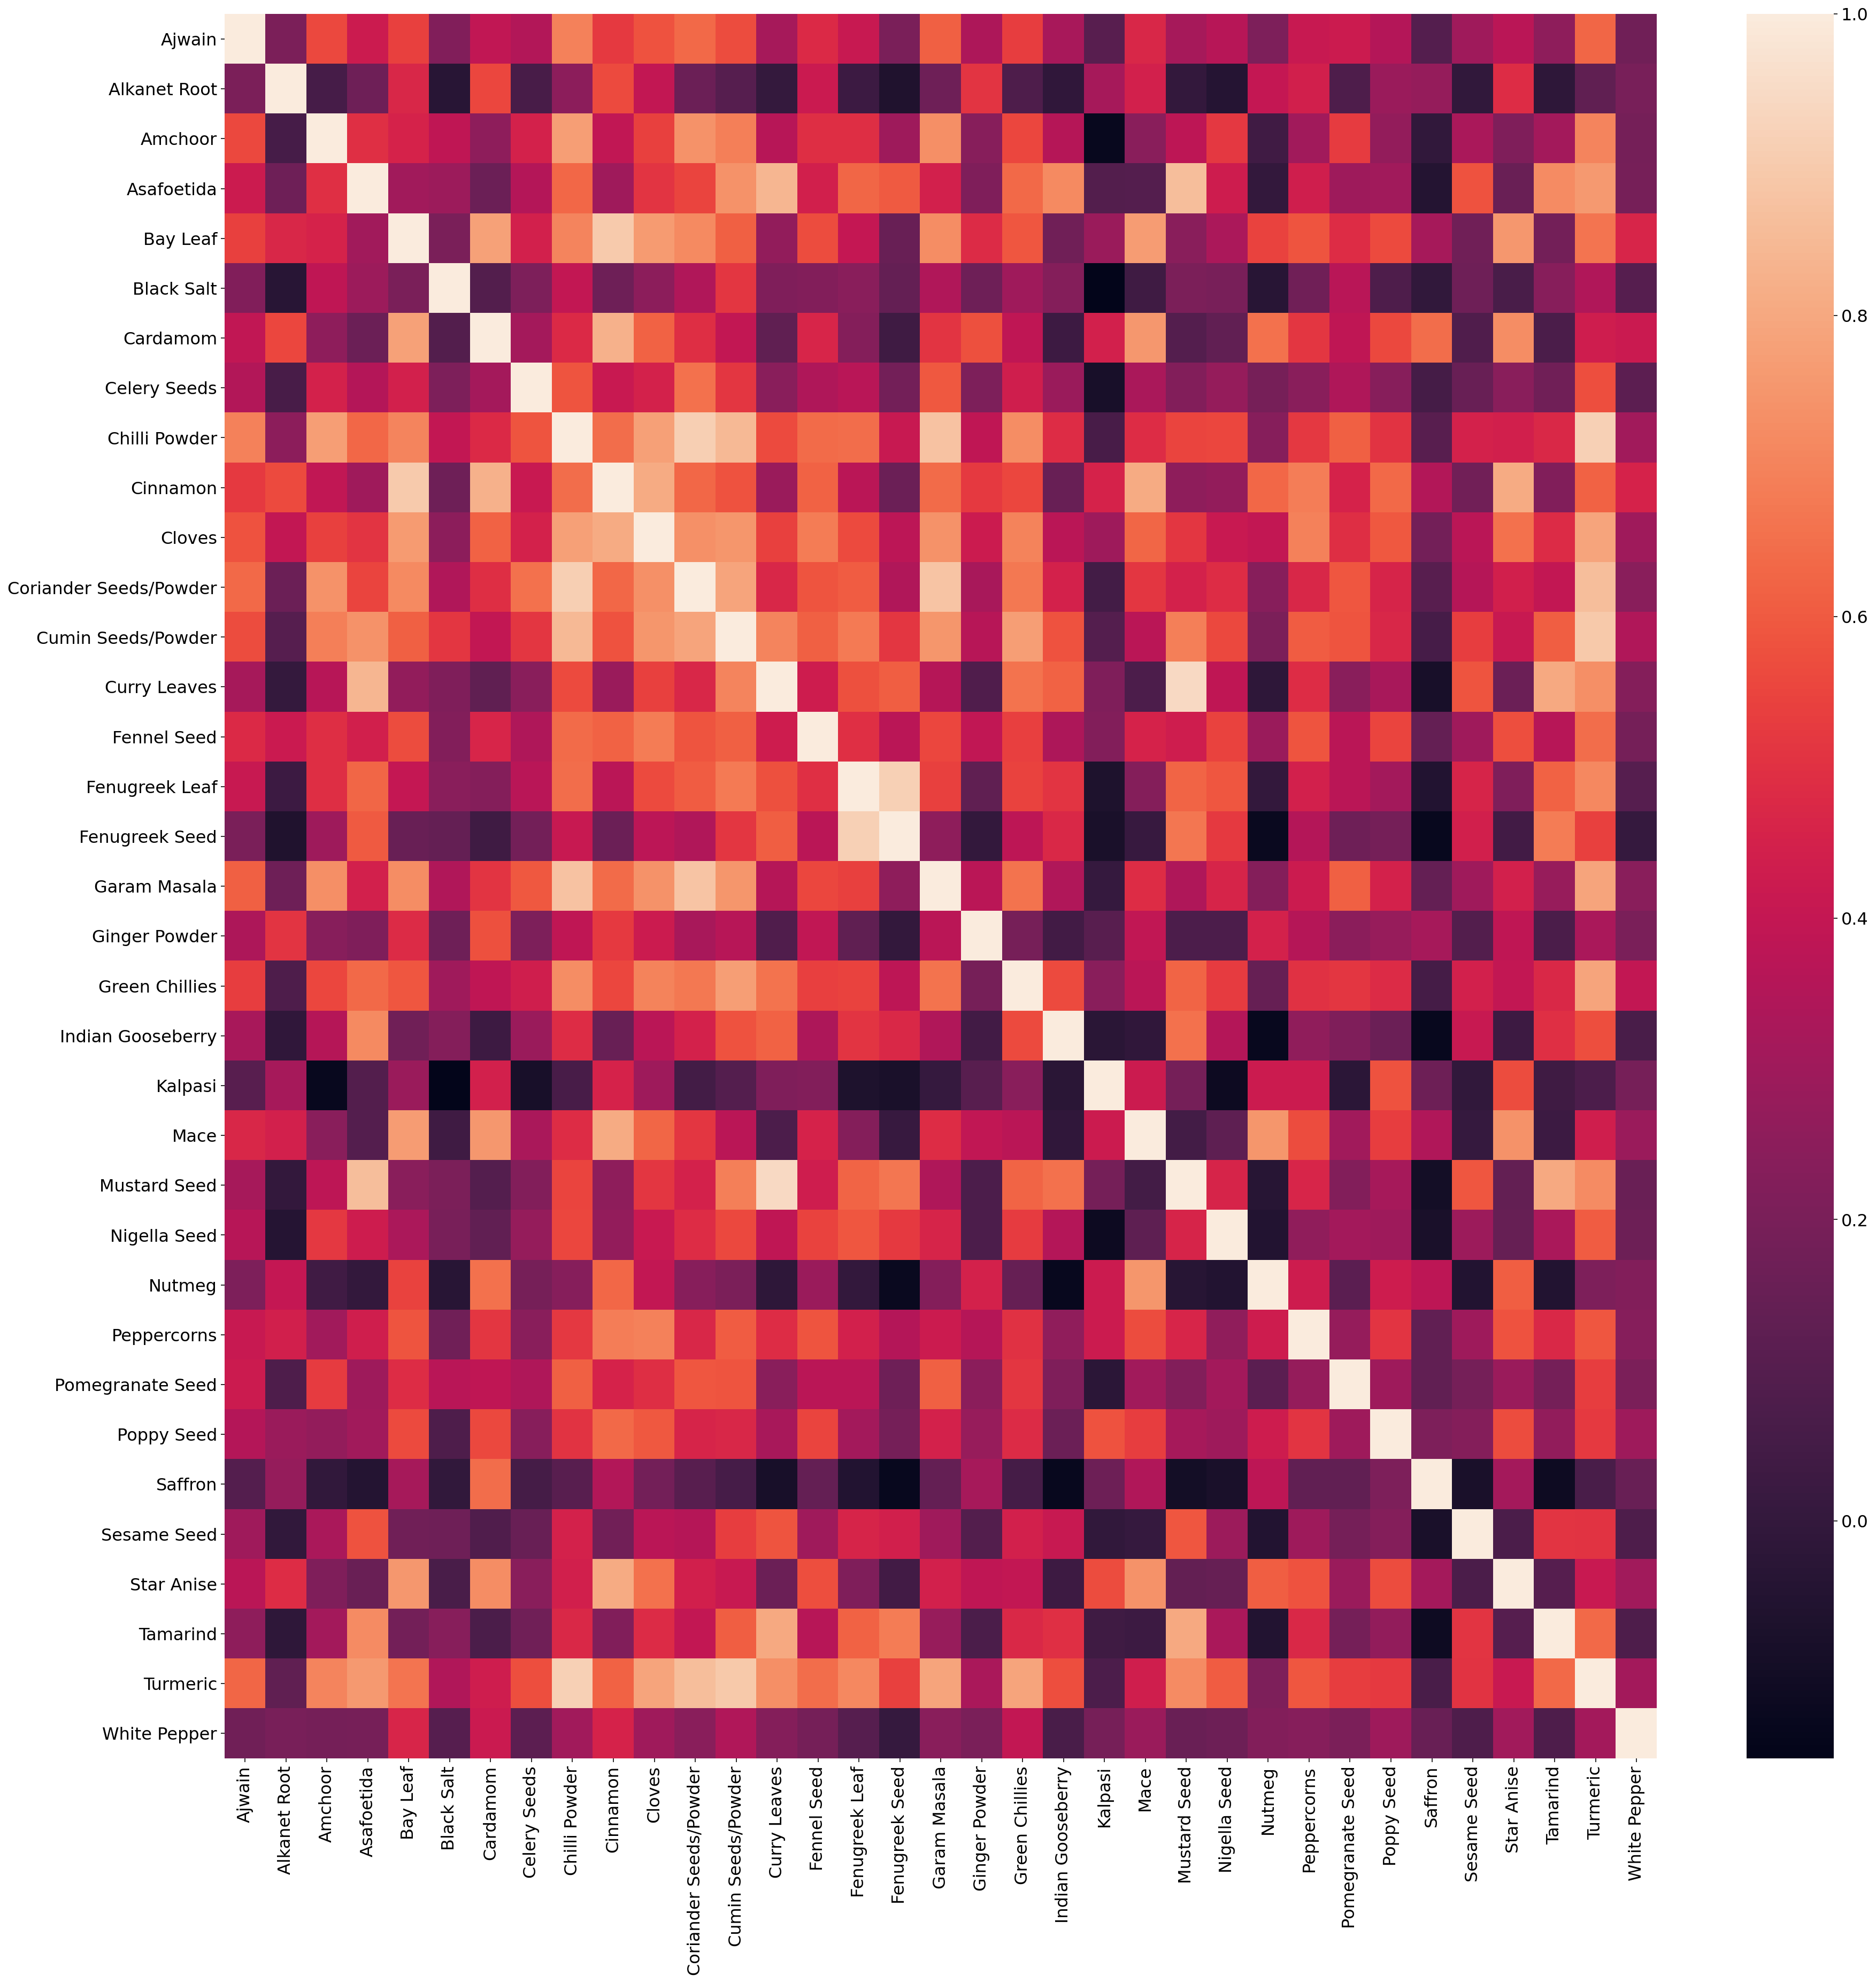

In [35]:
fig, ax = plt.subplots(1,1, figsize=(30,30))
sns.heatmap(spice_adj_freq.round(2).corr(), ax=ax)
plt.savefig("heatmap.png", format="PNG", dpi=300)

### ### Creating network

In [36]:
import networkx as nx 

In [37]:
nodes_data = [(i, {'count':spice_adj_freq.loc[i, i]}) for i in temp_name]

In [38]:
# most binary interactions 
binary_int = []
for i in temp_name:
    binary_int.append((i, spice_adj_freq.loc[i].sort_values(ascending=False).index[1]))

In [39]:
spice_dict = {i : spice_adj_freq.loc[i, i] for i in temp_name }

In [40]:
spice_dict

{'Ajwain': 5.218815820266792,
 'Alkanet Root': 0.07020828457758016,
 'Amchoor': 4.984788205008191,
 'Asafoetida': 24.596302363678916,
 'Bay Leaf': 10.695062017318044,
 'Black Salt': 1.6381933068102035,
 'Cardamom': 17.78609875965364,
 'Celery Seeds': 0.7956938918792418,
 'Chilli Powder': 37.959279194945005,
 'Cinnamon': 13.128949216007488,
 'Cloves': 28.34074420781652,
 'Coriander Seeds/Powder': 20.336999765972386,
 'Cumin Seeds/Powder': 43.59934472267727,
 'Curry Leaves': 27.615258600514856,
 'Fennel Seed': 7.208050549964897,
 'Fenugreek Leaf': 12.965129885326467,
 'Fenugreek Seed': 7.208050549964897,
 'Garam Masala': 18.34776503627428,
 'Ginger Powder': 1.357360168499883,
 'Green Chillies': 29.815118183945703,
 'Indian Gooseberry': 0.3978469459396209,
 'Kalpasi': 0.07020828457758016,
 'Mace': 1.2403463608705827,
 'Mustard Seed': 24.315469225368595,
 'Nigella Seed': 1.6615960683360638,
 'Nutmeg': 1.5211794991809033,
 'Peppercorns': 8.190966534051018,
 'Pomegranate Seed': 0.77229113035

In [41]:
edges_data = [] 
for i in temp_name:
    for j in temp_name:
        if i != j:
            if spice_adj_freq.loc[i,j] != 0.0:
                edges_data.append((i, j, {'weight':spice_adj_freq.loc[i,j], 'distance':1}))

In [42]:
#G = nx.from_pandas_adjacency(spice_adj_freq)
#BUILD THE INITIAL FULL GRAPH
G=nx.Graph()
G.add_nodes_from(nodes_data)
G.add_edges_from(edges_data)

In [43]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 35
Number of edges: 504
Average degree:  28.8000


In [44]:
deg_l = {i:G.degree(i) for i in temp_name} 

In [45]:
highest_centrality_node = max(deg_l.items(), key=lambda x: x[1])[0]

In [46]:
highest_centrality_node

'Asafoetida'

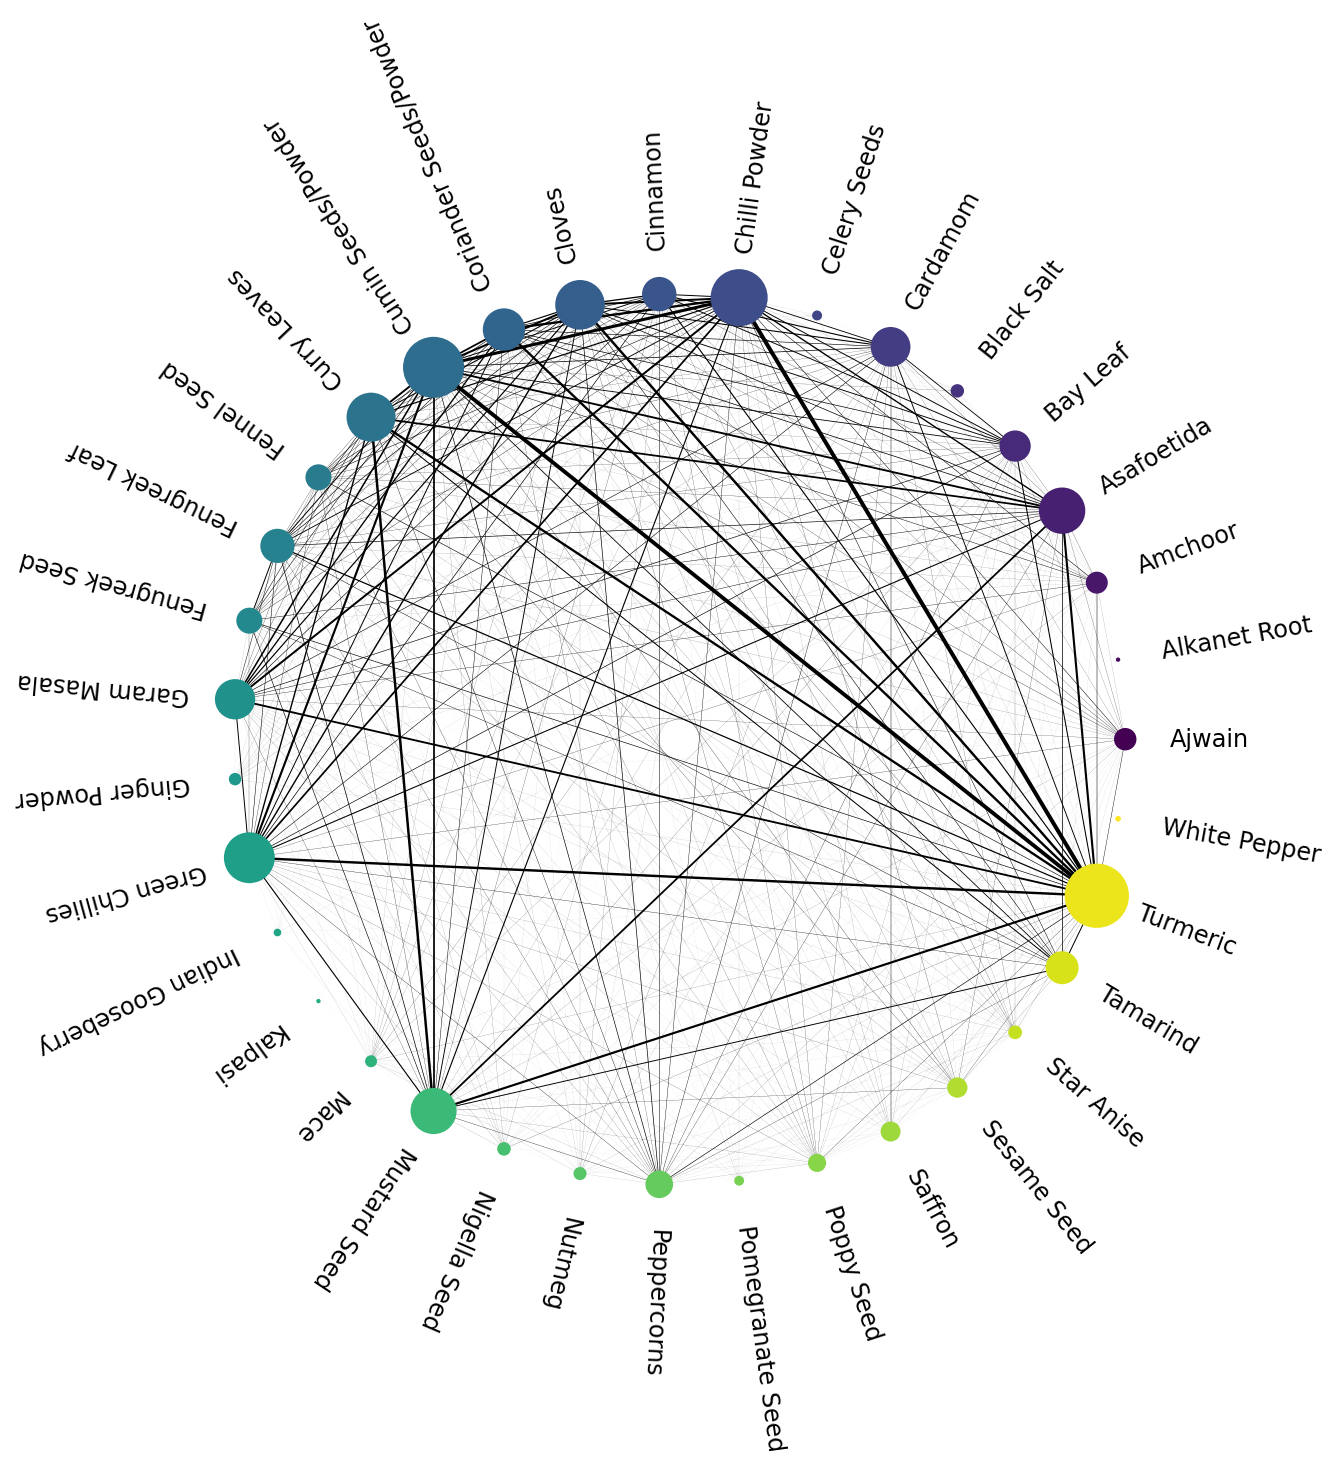

In [47]:
#Adopted from: https://stackoverflow.com/questions/43894987/networkx-node-labels-relative-position
n = len(nodes_data)
edges = G.edges()

weights = [G[u][v]['weight'] for u,v in edges]
w_arr = np.array(weights)
norm_weight =  (w_arr - w_arr.min())/(w_arr.max() - w_arr.min())


angle = []
angle_dict = {}
node_list = sorted(G.nodes())
for i, node in zip(np.arange(n),node_list):
    theta = 2.0*np.pi*i/n
    angle.append((np.cos(theta),np.sin(theta)))
    angle_dict[node] = theta
pos = {}
for node_i, node in enumerate(node_list):
    pos[node] = angle[node_i]
    
fig, ax = plt.subplots(figsize=(20,20))
margin=0.33
fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
ax.axis('equal')

nx.draw(G,pos=pos,with_labels=False, node_size=[spice_dict[k]*20 for k in spice_dict], width=norm_weight*2.0, node_color=np.arange(n), cmap=plt.cm.viridis, ax=ax)
description = nx.draw_networkx_labels(G,pos)

r = fig.canvas.get_renderer()
trans = plt.gca().transData.inverted()
for node, t in description.items():
    bb = t.get_window_extent(renderer=r)
    bbdata = bb.transformed(trans)
    radius = 1.1+bbdata.width/2
    position = (radius*np.cos(angle_dict[node]),radius* np.sin(angle_dict[node]))
    t.set_position(position)
    t.set_rotation(angle_dict[node]*360.0/(2.0*np.pi))
    t.set_clip_on(False)
plt.savefig("Graph.png", format="PNG", dpi=300)